In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [ ]:
def load_data(file_path):
    experts_df = pd.read_excel('expert.xlsx')
    experts_df['expertise'] = experts_df['expertise'].str.split(', ')
    return experts_df

In [ ]:
def prepare_data(experts_df):
    mlb = MultiLabelBinarizer()
    expertise_matrix = mlb.fit_transform(experts_df['expertise'])

    # Create positive and negative pairs
    pairs = []
    labels = []

    for i in range(len(expertise_matrix)):
        for j in range(len(expertise_matrix)):
            if i != j:
                pairs.append([expertise_matrix[i], expertise_matrix[j]])
                common_expertise = np.sum(expertise_matrix[i] & expertise_matrix[j])
                labels.append(1 if common_expertise > 0 else 0)

    pairs = np.array(pairs)
    labels = np.array(labels)

    train_pairs, val_pairs, train_labels, val_labels = train_test_split(pairs, labels, test_size=0.2)

    return {
        'train_pairs': train_pairs,
        'val_pairs': val_pairs,
        'train_labels': train_labels,
        'val_labels': val_labels,
        'expertise_matrix': expertise_matrix,
        'classes': mlb.classes_
    }

In [ ]:
def create_similarity_model(input_dim):
    input_a = tf.keras.layers.Input(shape=(input_dim,))
    input_b = tf.keras.layers.Input(shape=(input_dim,))

    # Add L2 regularization and dropout
    dense_a = tf.keras.layers.Dense(64,
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_a)
    dense_b = tf.keras.layers.Dense(64,
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_b)

    dropout_a = tf.keras.layers.Dropout(0.5)(dense_a)
    dropout_b = tf.keras.layers.Dropout(0.5)(dense_b)

    # Add another layer with regularization
    dense2_a = tf.keras.layers.Dense(32,
                                   activation='relu',
                                   kernel_regularizer=tf.keras.regularizers.l2(0.01))(dropout_a)
    dense2_b = tf.keras.layers.Dense(32,
                                   activation='relu',
                                   kernel_regularizer=tf.keras.regularizers.l2(0.01))(dropout_b)

    # Calculate similarity
    dot_product = tf.keras.layers.Dot(axes=1)([dense2_a, dense2_b])
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dot_product)

    model = tf.keras.Model(inputs=[input_a, input_b], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Reduced learning rate
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot Accuracy
    ax1.plot(history['accuracy'], color='#1f77b4', label='Train', linewidth=2)
    ax1.plot(history['val_accuracy'], color='#ff7f0e', label='Validation', linewidth=2)
    ax1.set_title('Model Accuracy', pad=15, fontsize=12, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=10)
    ax1.set_ylabel('Accuracy', fontsize=10)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(fontsize=10)
    ax1.set_ylim([0, 1])

    # Plot Loss
    ax2.plot(history['loss'], color='#1f77b4', label='Train', linewidth=2)
    ax2.plot(history['val_loss'], color='#ff7f0e', label='Validation', linewidth=2)
    ax2.set_title('Model Loss', pad=15, fontsize=12, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=10)
    ax2.set_ylabel('Loss', fontsize=10)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(fontsize=10)

    plt.tight_layout()
    fig.patch.set_facecolor('white')
    ax1.set_facecolor('white')
    ax2.set_facecolor('white')

    plt.savefig('training_metrics.png', bbox_inches='tight', dpi=300)
    print("Metrics plot saved as 'training_metrics.png'")
    plt.show()

In [ ]:
def train_and_convert_model(data, output_path='expert_similarity.tflite', epochs=100):
    model = create_similarity_model(data['expertise_matrix'].shape[1])

    # Add early stopping with more patience
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-5
        )
    ]

    # Train with smaller batch size
    history = model.fit(
        [data['train_pairs'][:, 0], data['train_pairs'][:, 1]],
        data['train_labels'],
        validation_data=(
            [data['val_pairs'][:, 0], data['val_pairs'][:, 1]],
            data['val_labels']
        ),
        epochs=epochs,
        batch_size=16,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate the model
    evaluation = model.evaluate(
        [data['val_pairs'][:, 0], data['val_pairs'][:, 1]],
        data['val_labels']
    )

    metrics = {
        'val_loss': evaluation[0],
        'val_accuracy': evaluation[1],
        'history': history.history
    }

    # Convert the trained model to TFLite format
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    with open(output_path, 'wb') as f:
        f.write(tflite_model)
    print(f"Model saved to {output_path}")

    return metrics, data['expertise_matrix'], data['classes']

In [ ]:
def get_recommendations_tflite(expert_id, expertise_matrix, expert_ids, tflite_path, top_n=3):
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    expert_idx = expert_ids.index(expert_id)
    expert_vector = expertise_matrix[expert_idx]

    similarities = []
    for i in range(len(expertise_matrix)):
        if i != expert_idx:
            interpreter.set_tensor(input_details[0]['index'],
                               np.array([expert_vector], dtype=np.float32))
            interpreter.set_tensor(input_details[1]['index'],
                               np.array([expertise_matrix[i]], dtype=np.float32))
            interpreter.invoke()
            similarity = interpreter.get_tensor(output_details[0]['index'])[0]
            similarities.append((expert_ids[i], similarity))

    similarities.sort(key=lambda x: x[1], reverse=True)
    return [x[0] for x in similarities[:top_n]]

Loading expert data...

Preparing data...

Training model and converting to TFLite...
Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4936 - loss: 1.4450 - val_accuracy: 0.5990 - val_loss: 0.7602
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5965 - loss: 0.7238 - val_accuracy: 0.5990 - val_loss: 0.6798
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5885 - loss: 0.6804 - val_accuracy: 0.5990 - val_loss: 0.6748
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5806 - loss: 0.6802 - val_accuracy: 0.5990 - val_loss: 0.6739
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5928 - loss: 0.6760 - val_accuracy: 0.5990 - val_loss: 0.6736
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5951 - loss: 0.6750 - val_accuracy: 0.5990 - val_loss: 0.6735
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5819 - loss: 0.6798 - val_accuracy: 0.5990 - val_loss: 0.6735
Epoch 8/50
248/248

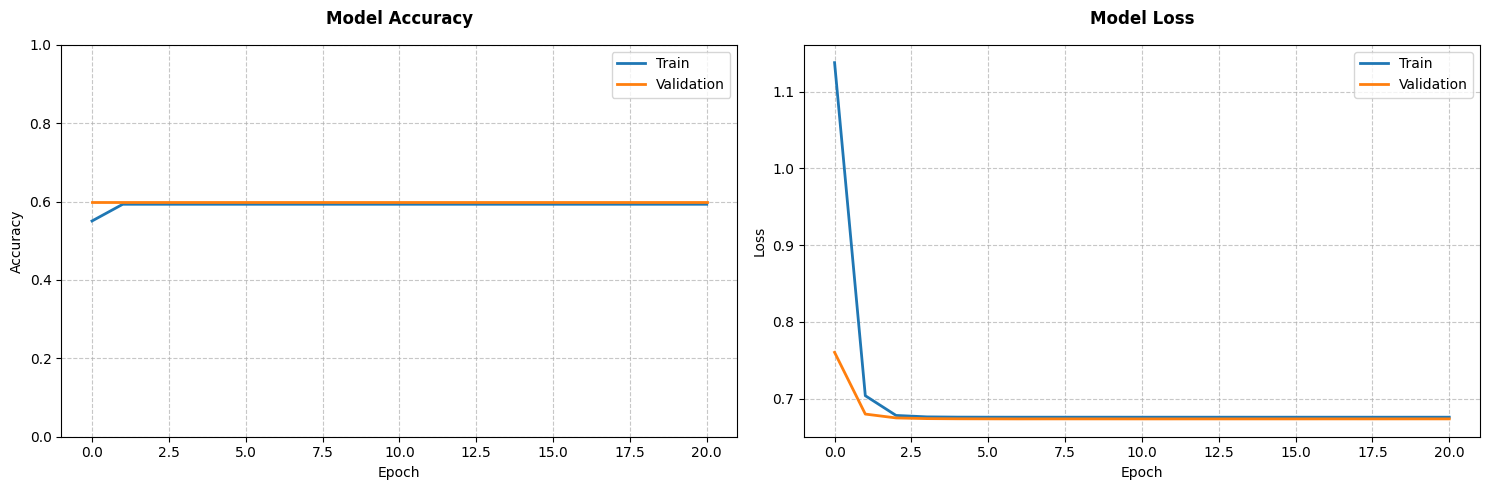


Getting recommendations for expert 101...

Recommended Experts:
 expert_id  name              expertise
       102  Budi [Statistika, Geometri]
       103 Tegar [Trigonometri, Fungsi]
       104 Aulia [Statistika, Kalkulus]

Original Expert Details:
 expert_id  name              expertise
       101 Fajar [Aritmatika, Himpunan]


In [ ]:
def get_expert_details(expert_ids, experts_df):
    expert_details = experts_df[experts_df['expert_id'].isin(expert_ids)].drop_duplicates('expert_id')
    return expert_details[['expert_id', 'name', 'expertise']]

if __name__ == "__main__":
    try:
        print("Loading expert data...")
        experts_df = load_data('expert.xlsx')

        print("\nPreparing data...")
        data = prepare_data(experts_df)

        print("\nTraining model and converting to TFLite...")
        metrics, expertise_matrix, expertise_classes = train_and_convert_model(data)

        print("\nModel Metrics:")
        print(f"Validation Loss: {metrics['val_loss']:.4f}")
        print(f"Validation Accuracy: {metrics['val_accuracy']:.4f}")

        print("\nGenerating metrics plots...")
        plot_metrics(metrics['history'])

        expert_ids = experts_df['expert_id'].unique().tolist()
        test_expert_id = 101
        print(f"\nGetting recommendations for expert {test_expert_id}...")

        recommended_expert_ids = get_recommendations_tflite(
            test_expert_id,
            expertise_matrix,
            expert_ids,
            'expert_similarity.tflite'
        )

        print("\nRecommended Experts:")
        recommended_details = get_expert_details(recommended_expert_ids, experts_df)
        print(recommended_details.to_string(index=False))

        print("\nOriginal Expert Details:")
        original_expert = get_expert_details([test_expert_id], experts_df)
        print(original_expert.to_string(index=False))

    except FileNotFoundError:
        print("Error: expert.xlsx file not found. Please ensure the file is in the correct directory.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")